Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import jiwer as wer
import matplotlib.pyplot as plt
from IPython import display

Loading the LJ Speech Dataset.

*Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

In [2]:
metadata_path = "./metadata.csv"
wavs_path = "./wavs/"

metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


Updating the column names:

In [3]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df.head(10)

,file_name,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi..."


Shuffling the dataset:
metadata_df.sample(frac=1): The sample method with frac=1 shuffles all the rows of the DataFrame. The frac parameter specifies the fraction of rows to return. Setting frac=1 means you want to return all rows, but in a randomly shuffled order.

In [4]:
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [5]:
metadata_df.head(10)

,file_name,normalized_transcription
0,LJ038-0258,The Dallas City-County Investigation Laborator...
1,LJ031-0133,"Jack Brooks, Homer Thornberry, and Albert Thom..."
2,LJ045-0011,by some rightwing groups centered in Dallas or...
3,LJ010-0229,Within a couple of years a second attempt to a...
4,LJ049-0014,The Commission regards such impromptu stops as...
5,LJ025-0049,is the specially animal function of animals an...
6,LJ040-0032,He accused his wife of preferring others to hi...
7,LJ002-0026,in the three years between eighteen thirteen a...
8,LJ038-0167,narrowly escaped death when a rifle bullet fir...
9,LJ002-0167,quotes a case which came within his own knowle...


Split the data into Training and Validation

In [6]:
split = int(len(metadata_df) * 0.90)
train_df = metadata_df[:split]
val_df = metadata_df[split:]

In [7]:
print("length of train df: ", len(train_df))
print("length of train df: ", len(val_df))

length of train df:  11790
length of train df:  1310


Preparing the vocabulary to be used

In [8]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'!? "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [9]:
print(char_to_num.get_vocabulary())

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!', '?', ' ']


In [11]:
print(char_to_num.vocabulary_size())

31


Making a preprocessing function for each audio file

In [12]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
    #processing the audio file
    #1. importing it, decoding it, removing dimensions of size 1 from the end and converting it to of type float32
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    #calculating the stft of the audio, deriving the magnitude only using tf.abs and finding the sqaure root such that 
    # we compress the range of values, making it easier for a neural network to learn from the data.
    spectogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)
    
    #we find the mean and standard deviation of the spectogram and normalize it.
    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / (stddevs + 1e-10)
    
    #processing the label
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    
    return spectogram, label

Creating Dataset Objects

In [13]:
batch_size = 8
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["file_name"]), list(train_df["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(val_df["file_name"]), list(val_df["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Visualizing the Data

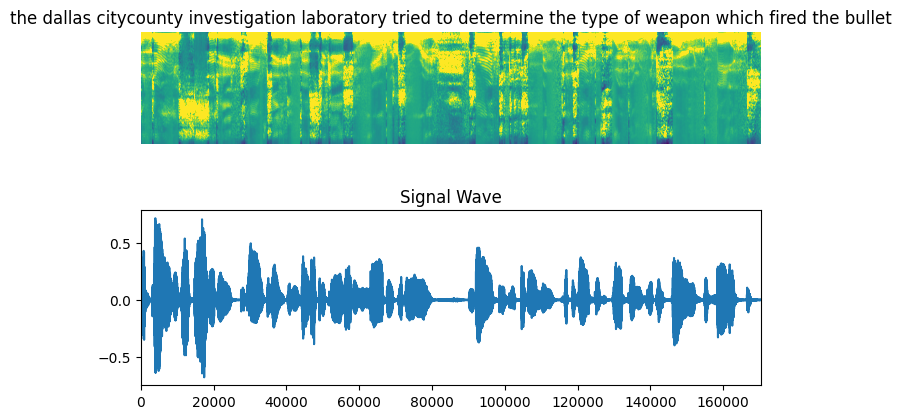

In [14]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label = batch[1][0]
    
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    
    file = tf.io.read_file(wavs_path + list(train_df["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

Model Building:
We first define the CTC Loss function

In [15]:
def CTCLoss(y_true, y_pred):
    #finding the no.of samples in a batch, length of input sequence and length of label and then converting
    # them into type int64
    batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    # Create tensors of input and label lengths for each sample in the batch.
    input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")
    
    #  Calculate the CTC loss for the batch and return it.
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

Now we'll define a model similar to DeepSpeech2 (more similiar to the LibriSpeech Topology)

In [16]:
# model pipeline
def build_model(input_dim, output_dim, rnn_layers = 5, rnn_units = 5):
    # model's input
    input_spectogram = layers.Input((None, input_dim), name="input")
    # Expand the dimensions to use 2D Convolutional Neural Networks
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
    
    # convolutional layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11,42],
        strides=[2,2],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="bn_1")(x)
    x = layers.ReLU(name="relu_1")(x)
    
    #convolutional layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11,21],
        strides=[1,2],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)
    x = layers.BatchNormalization(name="bn_2")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    # GRU layer
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
            
    # adding dense, relu and dropout layers
    x = layers.Dense(units=rnn_units * 2, name="dense_final")(x)
    x = layers.ReLU(name="dense_relu_1")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # model
    model = keras.Model(input_spectogram, output, name="DeepSpeech2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(optimizer=opt, loss=CTCLoss)
    return model
    

In [17]:
# building the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,784 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bn_1 (BatchNormalization)                      │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ relu_1 (ReLU)                                  │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bn_2 (BatchNormalization)                      │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,832 (101.58 MB)

 Trainable params: 26,628,704 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

Training and Evaluating

In [18]:
# a utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Using greedy search algorithm here. For complex tasks we can use Beam Search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get the output text back
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
        
    return output_text

In [19]:
# A callback class to output a few transcriptions during training
class CallBackEval(keras.callbacks.Callback):
    
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        
    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
             X, y = batch
             batch_predictions = model.predict(X)
             batch_predictions = decode_batch_predictions(batch_predictions)
             predictions.extend(batch_predictions)
             for label in y:
                 label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                 targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

Model training

In [20]:
epochs = 5
validation_callback = CallBackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/5

  11/1474 ━━━━━━━━━━━━━━━━━━━━ 33:44:43 83s/step - loss: 968.2429 

: 